# <font color=#0404B4>**SEMINAR - PHÂN TÍCH DỮ LIỆU THÔNG MINH** </font>

### <font color=#0404B4> Bảng thành viên nhóm </font>
|<center><div style="width:150px">MSSV</div><center>|<center><div style="width:290px">Họ và tên</div><center>|
|---------- |:-------------:|
| <center>20120032<center>  | <center>Phan Trường An<center> |
| <center>20120037<center>  | <center>Trần Thị Minh Anh<center> |
| <center>20120041<center>  | <center>Trần Kim Bảo<center> |
| <center>20120053<center>  |   <center>Nguyễn Thành Đạt<center>   |
| <center>20120071<center>  |<center>Nguyễn Thị Bích Hà<center> |
| <center>20120095<center>  | <center>Ngô Quang Hưng<center> |

# <font color=#0404B4>Import thư viện</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_theme()
pd.set_option("display.max_colwidth", 250)

c:\Users\admin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# !pip install locationtagger
# !pip install geotext
# !pip install geopy

In [2]:
from geotext import GeoText
from geopy.geocoders import Nominatim

<a name="2"></a>
# <font color=#0404B4> A. Tiền xử lý dữ liệu</font>


### 1. Đọc dữ liệu

In [3]:
train_df=pd.read_csv("train.csv")
train_df.shape

(7613, 5)

In [4]:
test_df=pd.read_csv("test.csv")
test_df.shape

(3263, 4)

In [5]:
sample_submission_df=pd.read_csv("sample_submission.csv")
sample_submission_df.shape

(3263, 2)

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
sample_submission_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


### 2. Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?
- `train_df`: Thông tin của tweet trên tập huấn luyện gồm: id, từ khóa, địa điểm gửi, nội dung và nhãn của tweet.
- `test_df`: Thông tin của tweet trên tập test gồm: id, từ khóa, địa điểm gửi, nội dung.
- `sample_submission_df`: định dạng nộp bài.

### 3. Có dữ liệu bị trùng lặp ở các dataframe không

In [9]:
def check_duplicated(dataframe):
    duplicated_rows = dataframe.duplicated()

    # In các hàng bị lặp lại
    if len(dataframe[duplicated_rows])>0:
        print('Có dòng dữ liệu bị lặp')
        display(dataframe[duplicated_rows])
    else:
        print('Không có dòng dữ liệu nào bị lặp')


Dataframe `train_df`

In [10]:
check_duplicated(train_df)

Không có dòng dữ liệu nào bị lặp


Dataframe `test_df`

In [11]:
check_duplicated(test_df)

Không có dòng dữ liệu nào bị lặp


Dataframe `sample_submission_df`

In [12]:
check_duplicated(sample_submission_df)

Không có dòng dữ liệu nào bị lặp


<h3> 4. Mỗi cột có ý nghĩa gì?</h3>

|STT|Tên cột dữ liệu | <center>Mô tả<center> | Ghi chú |
|--|:------:| ---| --- |
|1|id|<center>định danh của tweet<center>|
|2|keyword| <center>Từ khóa được lấy từ tweet<center>|Có thể thiếu|
|3|location|<center>Địa điểm đăng tweet<center>| Có thể thiếu|
|4|text| <center>Nội dung của tweet<center>||
|5|target|<center>Nhãn được gán cho tweet<center>|1: Thảm họa thực sự <br> 0: Không xảy ra thảm họa|



### 5. Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp?



Dataframe `train_df`

In [13]:
train_df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Dataframe `test_df`

In [15]:
test_df.columns

Index(['id', 'keyword', 'location', 'text'], dtype='object')

In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


- Nhận xét:
    - Dựa vào ý nghĩa của id và kích thước của `train_df` và `test_df`, nhận thấy rằng chúng ta có thể merge dữ liệu ở 2 dataframe để tạo thành 1 dataframe mới: `tweet_df`. Để tiện cho phần khám phá dữ liệu.

In [17]:
tweet_df=pd.concat([train_df,test_df])

In [18]:
tweet_df=tweet_df.sort_values(by="id").reset_index(drop=True)

In [19]:
check_duplicated(tweet_df)

Không có dòng dữ liệu nào bị lặp


In [20]:
tweet_df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [21]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 425.0+ KB


### 6. Với mỗi cột, các giá trị được phân bố như thế nào?

#### Cột có kiểu dữ liệu dạng số, và phân bố:


In [22]:
numerical_cols = tweet_df[tweet_df.select_dtypes(exclude=['object']).columns]
numerical_cols.head(5)

,id,target
0,0,NaN
1,1,1.0
2,2,NaN
3,3,NaN
4,4,1.0


- Với các cột dữ liệu dạng số ta sẽ tính % dữ liệu thiếu, min, max. Kết quả được lưu vào dataframe `nume_col_profiles_df`, với:
    - `missing_ratio`: % dữ liệu thiếu.
    - `min`: giá trị nhỏ nhất.
    - `max`: giá trị lớn nhất.

In [23]:
numerical_cols = tweet_df[tweet_df.select_dtypes(exclude=['object']).columns]

def missing_ratio(c):
    return  c.isna().sum()/len(c) * 100

def min(c):
    return c.min()

def max(c):
    return c.max()

nume_col_profiles_df = numerical_cols.agg([missing_ratio, min, max])
nume_col_profiles_df

,id,target
missing_ratio,0.0,30.001839
min,0.0,0.000000
max,10875.0,1.000000


- Nhận xét:
    - `id`: Không có dữ liệu thiếu, ID tweet nhỏ nhất là 0, lớn nhất là 10875.
    - `target`: Có 30% dữ liệu thiếu tương ứng với các tweet chưa được gán nhãn ở `test_df`.

#### Cột có kiểu dữ liệu phân loại, và phân bố:


In [24]:
object_cols = tweet_df[tweet_df.select_dtypes(include=['object']).columns]
object_cols.head(5)

,keyword,location,text
0,NaN,NaN,Just happened a terrible car crash
1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
4,NaN,NaN,Forest fire near La Ronge Sask. Canada


- Với các cột categorical, ta tính tỉ lệ % dữ liệu thiếu, số lượng giá trị khác nhau, phân bố của các giá trị khác nhau. Kết quả được lưu vào dataframe `cate_col_profiles_df`, với:
    - `missing_ratio`: % dữ liệu thiếu
    - `num_diff_vals`: số lượng giá trị khác nhau <em>(không xét giá trị thiếu)</em>
    - `ratio_diff_vals`: phân bố của các giá trị khác nhau <em>(không xét giá trị thiếu)</em>.

In [25]:
def num_diff_vals(col):
    return len(col.value_counts())

def ratio_diff_vals(col):
    return np.round(col.value_counts(normalize=True),2).to_dict()

cate_col_profiles_df=object_cols.agg([missing_ratio,num_diff_vals,ratio_diff_vals])
cate_col_profiles_df

,keyword,location,text
missing_ratio,0.799926,33.449798,0.0
num_diff_vals,221,4521,10678
ratio_diff_vals,"{'ablaze': 0.0, 'lava': 0.0, 'loud%20bang': 0.0, 'mass%20murder': 0.0, 'massacre': 0.0, 'mayhem': 0.0, 'meltdown': 0.0, 'military': 0.0, 'mudslide': 0.0, 'natural%20disaster': 0.0, 'nuclear%20disaster': 0.0, 'nuclear%20reactor': 0.0, 'obliterate'...","{'USA': 0.02, 'New York': 0.02, 'United States': 0.01, 'London': 0.01, 'Canada': 0.01, 'Nigeria': 0.01, 'India': 0.0, 'Worldwide': 0.0, 'Los Angeles, CA': 0.0, 'UK': 0.0, 'Kenya': 0.0, 'Washington, DC': 0.0, 'Mumbai': 0.0, 'United Kingdom': 0.0, ...","{'11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...': 0.0, '#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestna..."


- Nhận xét:
    - `location`: xuất hiện nhiều tweet không có địa chỉ đăng(33,45%), số lượng địa điểm lớn: 4521 địa điểm.
    - `keyword`: vẫn xuất hiện các tweet không trích dẫn được từ khóa, số lượng không quá lớn: 221 cụm từ khóa.
    - `text`: Không bị thiếu dữ liệu, nhưng số lượng nội dung chỉ là 10678 < 10875 (số lượng bài tweet). Có thể là do 1 số sự kiện/vấn đề nào đó.

###  7. Có cột nào cần phải tiền xử lý hay không?


- Nhận xét:
    - Qua kiểm tra dữ liệu, ta có thể thấy ở thuộc tính `location` có rất nhiều giá trị(4521 địa điểm) xấp xỉ bằng 1/2 tổng 2 tập `train_df` và `test_df` cộng lại. Thực hiện kiểm tra và xử lý về dạng chuẩn nhất có thể.

#### 1. Xóa các địa điểm bị lỗi ký tự, xuất hiện ký tự đặc biệt nhiều:


Thực hiện xóa các hàm có ký tự đặc biệt nhiều hơn 1/4 so với độ dài của chuỗi. Và nếu trong cell đang xét có từ nào trên 2 ký tự thì thực hiện trả về *(Chỉ lấy 1 từ cuối)*

In [26]:
def del_special_string(c):
  if not(c is np.nan):
    special_char=re.sub('[\w^\s\.]+' ,'', c)
    scale=len(special_char)/len(c)
    if scale > 1/4:
      words=re.findall('[a-zA-Z]{2,}',c)
      if len(words)>0:
        return words[-1]
      return np.nan
    else:
      return c
  return np.nan

Thực hiện chạy hàm `del_special_string` cho tất cả các dữ liệu trong cột `location`

In [27]:
tweet_df.location.apply(del_special_string).str.strip().replace('',np.nan).unique().__len__()

4352

In [28]:
tweet_df.location=tweet_df.location.apply(del_special_string).str.strip().replace('',np.nan)

Đếm số lần địa điểm được sử dụng

In [29]:
location_count_df=tweet_df.location.value_counts().to_frame().reset_index().rename(columns={"location":"counts","index":"location"})
location_count_df

,location,counts
0,USA,146
1,New York,112
2,United States,65
3,London,60
4,Nigeria,46
...,...,...
4346,buenos aires argentina,1
4347,everydaynigerian@gmail.com,1
4348,"Surulere Lagos,Home Of Swagg",1
4349,"MontrÌ©al, QuÌ©bec",1


In [30]:
location_array=location_count_df.location

#### 2.  Lọc các dữ liệu có tên thành phố hoặc tên quốc gia

##### Trích những tên thành phố và quốc gia *(đúng chuẩn)*

Tạo dataframe chứa thông tin: thành phố và quốc gia dựa trên các địa chỉ *(unique)*

In [31]:
location_dict={"city":[],"country":[]}
for location_str in location_array:

  if isinstance(location_str, str):
    places = GeoText(location_str)

    if len(places.cities)>0:
      if len(places.cities)>1:
        result=', '.join(places.cities)
        location_dict["city"].append(result)
      else :
        location_dict["city"].append(places.cities[0])
    else :
        location_dict["city"].append(np.nan)

    if len(places.countries)>0:
      location_dict["country"].append(places.countries[0])
    else :
      location_dict["country"].append(np.nan)
  else:
    location_dict["city"].append(np.nan)
    location_dict["country"].append(np.nan)


In [32]:
location_df=pd.DataFrame(location_dict)
location_df

,city,country
0,NaN,NaN
1,New York,NaN
2,NaN,United States
3,London,NaN
4,NaN,Nigeria
...,...,...
4346,NaN,NaN
4347,NaN,NaN
4348,NaN,NaN
4349,NaN,NaN


##### Điền tên quốc gia cho các tweet chỉ có tên thành phố

In [33]:
def get_country(city):
  if not (city is np.nan):
    geolocator = Nominatim(user_agent="my_app")
    location = geolocator.geocode(city)
    if location:
      return location.raw['display_name'].split(",")[-1].strip()
    return np.nan
  return np.nan

In [34]:
location_fill_country=location_df[~(location_df.city.isna()) & (location_df.country.isna())]

In [35]:
# Đã chạy và lưu kết quả vào file fill_country.csv
countries = location_fill_country.city.iloc[:5].apply(get_country)

location_df.loc[countries.index, 'country'] = countries.values
location_df

,city,country
0,NaN,NaN
1,New York,United States
2,NaN,United States
3,London,United Kingdom
4,NaN,Nigeria
...,...,...
4346,NaN,NaN
4347,NaN,NaN
4348,NaN,NaN
4349,NaN,NaN


Xuất file `fill_country.csv` sau khi đã điền: để thuận tiện cho các lần chạy sau

In [36]:
location_df["location"]=pd.Series(location_array)

In [37]:
location_df.to_csv("fill_country.csv",index=False,header=True)

Đọc lại dữ liệu từ `fill_country.csv`

In [38]:
location_df=pd.read_csv("fill_country.csv")

#### 3. Chuẩn hóa các thông tin bị trống cả tên thành phố và quốc gia

Lọc các tweet bị trống thông tin ở 2 cột thành phố và quốc gia

In [39]:
location_nan_all_df=location_df[(location_df.city.isna()) & (location_df.country.isna())]
location_nan_all_df

,city,country,location
0,NaN,NaN,USA
7,NaN,NaN,Worldwide
9,NaN,NaN,UK
12,NaN,NaN,California
20,NaN,NaN,"California, USA"
...,...,...,...
4344,NaN,NaN,todaysbigstock.com
4346,NaN,NaN,buenos aires argentina
4347,NaN,NaN,everydaynigerian@gmail.com
4348,NaN,NaN,"Surulere Lagos,Home Of Swagg"


Hàm trả về tên quốc gia cho location chưa chuẩn hóa *(nếu có đề cập)*

In [40]:
def get_country_nan_all(c):
  geolocator = Nominatim(user_agent='myencoder', timeout=10)
  first = geolocator.geocode(c)
  if first:
    place=GeoText(first.address)
    if len(place.countries)<1:
      return first.raw['display_name'].split(",")[-1].strip()
    else :
      return place.countries[0]
  else :
    return np.nan

In [41]:
location_count_df[location_count_df.counts>1].counts.sum()

3514

- Nhận xét:
    - Thực hiện chuẩn hóa cho các địa điểm xuất hiện nhiều hơn 1 lần.
    - Theo tìm hiểu để có thể lấy được tên các quốc gia chưa được chuẩn hóa trong ngôn ngữ tự nhiên. Nhóm quyết định xử dụng thư viện `geopy`: truy cập lấy từ API từ [OpenStreetMap Nominatim](https://nominatim.openstreermap.org). Cho phép lấy được cả các thông tin chưa được chuẩn hóa dựa trên gợi ý từ API. Tuy nhiên với điều khoản chỉ có thểm lấy 1 địa chỉ/s và bị giới hạn số lần yêu cầu. Nên khó khăn trong việc chuẩn hóa toàn bộ.


In [42]:
len_NanCountrySuggest=location_count_df[location_count_df.counts>1].shape[0]

In [43]:
location_nan_all_df[location_nan_all_df.index<len_NanCountrySuggest]

,city,country,location
0,NaN,NaN,USA
7,NaN,NaN,Worldwide
9,NaN,NaN,UK
12,NaN,NaN,California
20,NaN,NaN,"California, USA"
...,...,...,...
719,NaN,NaN,far away
723,NaN,NaN,hyderabad
725,NaN,NaN,434
726,NaN,NaN,"sydney, australia"


In [44]:
start_idx=0
end_idx=100
steps=100
# n=location_nan_all[location_nan_all.index<len_NanCountrySuggest].shape[0]
n=0
while(True):
    if end_idx>n:
        countries = location_nan_all_df.location.iloc[start_idx:n].apply(get_country_nan_all)
        location_df.loc[countries.index, 'country'] = countries.values
        break
    countries = location_nan_all_df.location.iloc[start_idx:end_idx].apply(get_country_nan_all)
    location_df.loc[countries.index, 'country'] = countries.values
    print(end_idx)
    start_idx+=steps
    end_idx+=steps

Xuất file `fill_locatioin.csv` sau khi đã điền: để thuận tiện cho các lần chạy sau

In [45]:
location_df.to_csv("fill_location.csv",index=False,header=True)

In [46]:
location_nomalize_df=pd.read_csv("fill_location.csv")

In [47]:
location_nomalize_df.head(10)

,city,country,location
0,NaN,NaN,USA
1,New York,United States,New York
2,NaN,United States,United States
3,London,United Kingdom,London
4,NaN,Nigeria,Nigeria
5,NaN,Canada,Canada
6,NaN,India,India
7,NaN,NaN,Worldwide
8,Los Angeles,United States,"Los Angeles, CA"
9,NaN,NaN,UK


In [48]:
location_nomalize_df.loc[location_nomalize_df.location=="Worldwide","country"]="Worldwide"

Thực hiện chuẩn hóa dữ liệu vào tập dữ liệu `train_df` và `test_df`

In [49]:
train_df = train_df.merge(location_nomalize_df, how='left',on ="location")
test_df = test_df.merge(location_nomalize_df, how='left',on ="location")

In [50]:
train_df=train_df[["id", "keyword", "city", "country", "location", "text", "target"]]

In [51]:
train_df.head()

,id,keyword,city,country,location,text,target
0,1,NaN,NaN,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [52]:
test_df=test_df[["id", "keyword", "city", "country", "location", "text"]]

In [53]:
test_df.head()

,id,keyword,city,country,location,text
0,0,NaN,NaN,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<a name="2"></a>
# <font color=#0404B4> B. Khám phá dữ liệu</font>


### Case 1: tìm ra các target bằng 1 hay có những keyword nào?

**Import thư viện**

In [57]:
from wordcloud import WordCloud,STOPWORDS 

**Bước 1:** Tiền xử lý dữ liệu

Ta tiến hành lọc ra các sample có keyword không phải NaN và có target bằng 1 (disaster).

In [58]:
case1Train = train_df
# case1Train.head()
trainTarget1= case1Train[case1Train['keyword'].notnull()]
trainTarget1= trainTarget1[trainTarget1['target']==1]
trainTarget1.head()

,id,keyword,city,country,location,text,target
31,48,ablaze,Birmingham,NaN,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1
33,50,ablaze,NaN,NaN,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1
37,55,ablaze,NaN,NaN,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA,1
38,56,ablaze,NaN,NaN,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende... http://t.co/wDUEaj8Q4J,1
46,66,ablaze,NaN,NaN,"GREENSBORO,NORTH CAROLINA",How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr,1


**Bước 2:** Trực quan hóa bằng word cloud

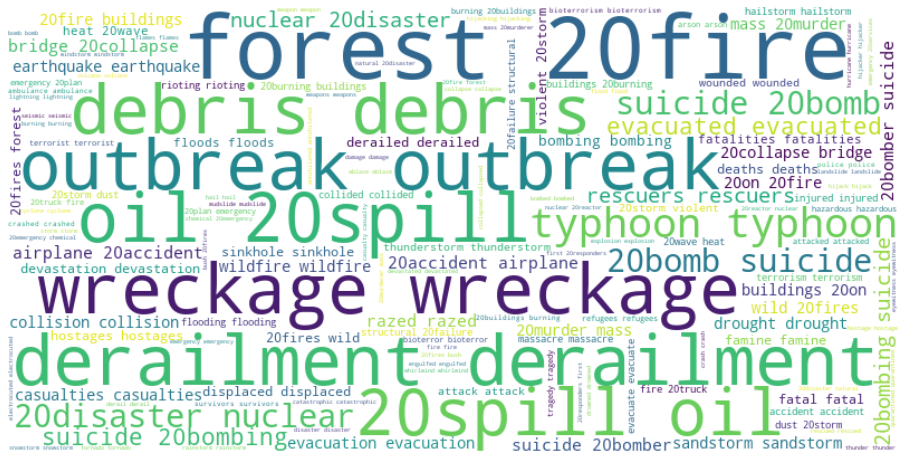

In [59]:
# Assuming your data is in a pandas DataFrame called 'trainTarget1'
keywords = trainTarget1['keyword'].dropna().tolist()

# Concatenate the keywords into a single string
text = ' '.join(keywords)

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Bước 3:** Để có thể quan sát rõ hơn về số lần keyword xuất hiện, ta thêm 1 bước trực quan hóa dữ liệu bằng biểu đồ cột. 

Trong đó trục x thể hiện `keyword`, trục y thể hiện `số lần` keyword đó xuất hiện

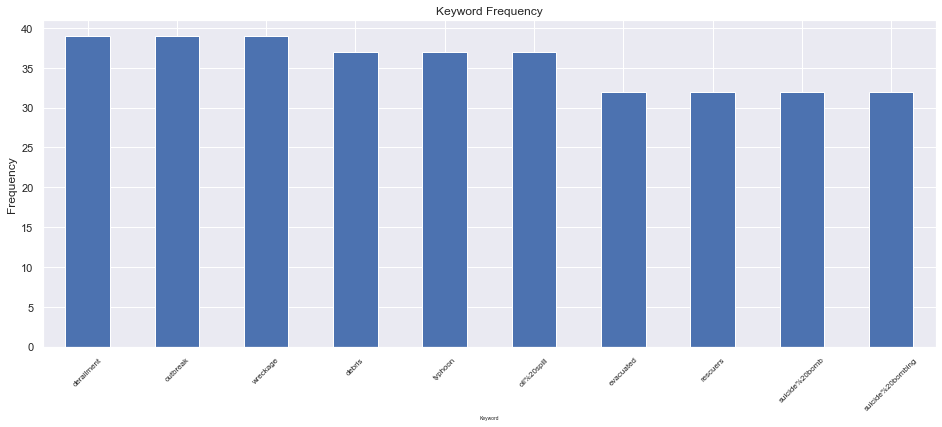

In [60]:
keywords_counts = trainTarget1['keyword'].value_counts().sort_values(ascending=False).head(10)

# Plotting the bar chart
plt.figure(figsize=(16, 6))
keywords_counts.plot(kind='bar')
plt.xlabel('Keyword',fontsize=5)
plt.ylabel('Frequency')
plt.title('Keyword Frequency')
plt.xticks(rotation=45,fontsize=8)
plt.show()

> Các target xuất hiện ở top 10 khá đồng đều, không có sự chênh lệch nhiều

### Case 2: Liệu có những mối quan hệ nào giữa `location` và cột `target`?

**Import thư viện**

In [61]:
import plotly.graph_objs as go
from plotly.offline import iplot

**Bước 1:** Tiền xử lý dữ liệu

Vì cột `location` có quá nhiều dữ liệu thiếu nên ta xử lý bằng cách phân ra, địa điểm đã biết và địa điểm chưa được xác định.

In [62]:
train_ex=train_df.copy()
train_ex['keyword']=train_ex['keyword'].fillna('Unknown')
train_ex['location']=train_ex['location'].fillna('Unknown')
train_ex['location']=train_ex['location'].apply(lambda x: 'Known' if x != 'Unknown' else x)

location_count=train_ex['location'].value_counts()
print(location_count)
location=location_count.keys()
lcount=location_count.values

Known      5078
Unknown    2535
Name: location, dtype: int64


**Bước 2:** Trực quan bằng `donut chart`

`Donut chart` rất phù hợp để quan sát tỉ lệ tweet có địa điểm đã biết và chưa biết.

In [63]:
pie_chart1=go.Pie(labels=location,values=lcount,hole=0.6)

my_layout=go.Layout(title='Biểu đồ biểu diễn tỉ lệ mức độ nghiêm trọng theo từng kiểu địa điểm',
                    height=500,width=800)

iplot({'data':pie_chart1, 'layout':my_layout})


***Nhận xét***:
- Quan sát biểu đồ, ta thấy lượng địa điểm chưa biết chiếm 1/3 so với tổng thể.
> Dữ liệu thiếu khá nhiều, cần trực quan kỹ hơn để đưa ra nhận xét. Ta xác định số lượng địa điểm biết và chưa biết dựa trên 2 nhóm tweet 1 và 0.


**Bước 3:** Tính các tham số cần thiết cho việc trực quan.

In [64]:
unknown=train_ex.loc[train_ex['location']=='Unknown']['target'].value_counts()
known=train_ex.loc[train_ex['location']=='Known']['target'].value_counts()
utarget=unknown.keys()
ucount=unknown.values
ktarget=known.keys()
kcount=known.values

target_count=train_ex['target'].value_counts()
target=target_count.keys()
tcount=target_count.values
total=sum(tcount)

**Bước 4**: Trực quan bằng `Nest chart`.

`Nest chart` được dùng khi cần các mối quan hệ cha và con trong biểu đồ.

In [65]:
import plotly.graph_objs as go

data = [
go.Pie(values=[tcount[1],tcount[0]],
    labels=[1,0],
    domain={'x':[0.2,0.8], 'y':[0.1,0.9]},
    hole=0.5,
    direction='clockwise',
    sort=False,
    marker={'colors':['#CB4335','#2E86C1']},
    ),
   
    go.Pie(values=[kcount[1],ucount[1],kcount[0],ucount[0]],
    labels=['Known-1','Unknown-1','Known-0','Unknown-0'],
    domain={'x':[0.1,0.9], 'y':[0,1]},
    hole=0.75,
    direction='clockwise',
    sort=False,
    marker={'colors':['#EC7063','#F1948A','#5DADE2','#85C1E9']},
    showlegend=False)]
my_layout = go.Layout(title='Biểu đồ biểu diễn tỉ lệ địa điểm có thông tin và chưa có thông tin dựa trên tweet 0 và 1',
                      height=500, width=800,
                      annotations=[{
                          'font': {
                              'size': 20
                          },
                          'showarrow': False,
                          'text':f'{total}',
                          'hovertext': f'Total: {total}',
                          'x': 0.5,
                          'y': 0.5,
                        
                      }])

fig = go.Figure(data=data, layout=my_layout)

iplot(fig)

***Nhận xét***:
- Với tweet 1 và tweet 0, lượng địa điểm đã biết có xu hướng cao hơn khoảng gấp đôi so với địa điểm chưa biết. Điều này cũng khá tương đồng với tỉ lệ khi trực quan tổng thể.
> Có thể kết luận rằng, số lượng địa điểm đã biết và chưa biết hầu như không có liên hệ với lượng tweet o và 1. 
>> Thử liên hệ cột `location` với cột `target` theo cách khác với case 3.

### Case 3: Lúc tìm được location hay xảy ra thảm hoạ, biến cố, xem có các keyword là gì?

**Bước 1:** Tiền xử lý dữ liệu.

Ta lọc ra các sample có `keyword` khác `NaN`, `target` bằng `1` và `location` khác `NaN`.

In [66]:
case3Train = train_df
# case3Train.head()
trainTarget3= case3Train[case3Train['keyword'].notnull()]
trainTarget3= trainTarget3[trainTarget3['target']==1]
trainTarget3= trainTarget3[trainTarget3['location'].notnull()]
trainTarget3.head()

,id,keyword,city,country,location,text,target
31,48,ablaze,Birmingham,NaN,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1
33,50,ablaze,NaN,NaN,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1
37,55,ablaze,NaN,NaN,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA,1
46,66,ablaze,NaN,NaN,"GREENSBORO,NORTH CAROLINA",How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr,1
50,73,ablaze,NaN,NaN,"Sheffield Township, Ohio",Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k,1


**Bước 2:** Ta tiến hành trực quan bằng biểu đồ cột, trong đó trục x thể hiện các `location`, trục y thể hiện `số lần` mà location đó xảy ra disater. Sắp xếp giảm dần ta được biểu đồ như bên dưới

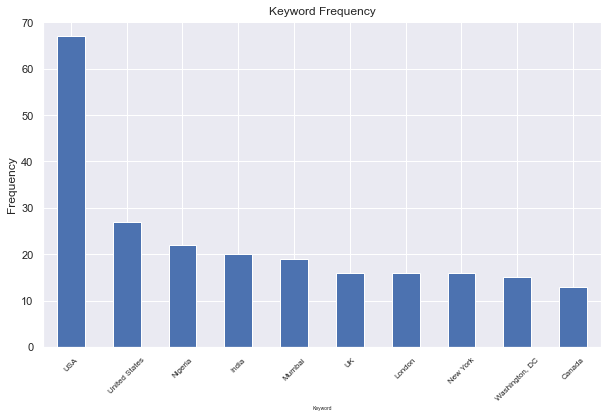

In [67]:
keywords_counts = trainTarget3['location'].value_counts().sort_values(ascending=False).head(10)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
keywords_counts.plot(kind='bar')
plt.xlabel('Keyword',fontsize=5)
plt.ylabel('Frequency')
plt.title('Keyword Frequency')
plt.xticks(rotation=45,fontsize=8)
plt.show()

***Nhận xét***:
- USA là nơi xảy ra thảm họa nhiều nhất.
> Ta tiến hành phân tích các keyword có liên quan đến USA.

**Bước 3**: Từ dữ liệu đã lọc ở bước trên, ta thêm 1 bước lấy ra các sample có `location` là `USA`. Sau đó trực quan bằng biểu đồ cột, trục x thể hiện `keyword`, trục y thể hiện `số lần` keyword đó xuất hiện

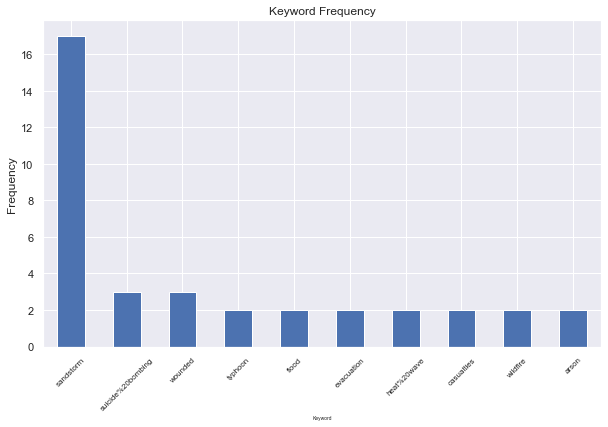

In [68]:
trainTarget3= trainTarget3[trainTarget3['location']=="USA"]

keywords_counts = trainTarget3['keyword'].value_counts().sort_values(ascending=False).head(10)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
keywords_counts.plot(kind='bar')
plt.xlabel('Keyword',fontsize=5)
plt.ylabel('Frequency')
plt.title('Keyword Frequency')
plt.xticks(rotation=45,fontsize=8)
plt.show()


**Nhận xét:**
- Từ biểu đồ trên, ta dễ dàng nhận thấy `sandStorm` chiếm ưu thế hơn hẳn trong top 10, với số lượng vượt trội.

> Từ phân tích trên có thể rút ra được, nếu là USA thì khả năng xảy ra thảm họa "sandstorm" là khá cao.

### Case 4: Thống kê cột `text` theo số lượng chữ trên dòng, theo câu để kiểm tra có điểm bất thường nào không?



**Import thư viện**

In [69]:
import string
import nltk

**Tiền xử lý** 

In [70]:

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def keyword_preprocess(text):
    """Clean keyword by removing '%20'"""
    if pd.notnull(text):
        text = text.replace("%20", " ")
    else:
        text = ''

    return text
train_df['keyword'] = train_df['keyword'].apply(keyword_preprocess)
test_df['keyword'] = test_df['keyword'].apply(keyword_preprocess)

In [71]:
def text_preprocess(df):
    """Clean text by removing url and @someone"""
    df['text'] = df['text'].apply(lambda x: remove_URL(x))
    df['text'] = df['text'].apply(lambda x: remove_html(x))
    df['text'] = df['text'].apply(lambda x: remove_emoji(x))
    df['text'] = df['text'].apply(lambda x: remove_punct(x))
    return df

train_df=text_preprocess(train_df)
test_df=text_preprocess(test_df)

**Bước 1**: Tạo cột đếm số lượng chữ của cột `text`.

In [72]:
def word_count(sample):
    sample_list=sample.split()
    return len(sample_list)

In [73]:
train_df['word_count']=train_df['text'].apply(word_count)

**Bước 2:** Tạo cột số lượng chữ và số lượng chữ trung bình của cột `text`.

In [74]:
train_df['length']=train_df['text'].str.len()
train_df['mean_word_length']=train_df['text'].map(lambda rev: np.mean([len(word)for word in rev.split()]))

**Bước 3**: Tính số lượng chữ trung bình trên câu.

In [75]:
train_df['mean_sentence_length']=train_df['text'].map(lambda rev: np.mean([len(sentence)for sentence in nltk.tokenize.sent_tokenize(rev)]))

**Bước 4**: Trực quan bằng `line chart` và `boxplot`.


- `Boxplot` phù hợp để kiểm tra độ phân bố dữ liệu của các cột số lượng từ, độ dài, số lượng từ trung bình và số lượng từ trung bình trên câu.
- `Line chart` phù hợp để kiểm tra biến động, giúp thể hiện rõ được biến động của lượng tweet 0 và 1 dựa trên số lượng từ, độ dài, số lượng từ trung bình và số lượng từ trung bình trên câu.

In [76]:
def visualize(col):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # Create a figure with a larger size
    
    sns.boxplot(y=train_df[col], hue=train_df['target'], ax=axes[0])  # Plot the boxplot on the left subplot
    axes[0].set_ylabel(col, labelpad=12.5)
    
    sns.kdeplot(train_df[col], hue=train_df['target'], ax=axes[1])  # Plot the kdeplot on the right subplot
    axes[1].legend(train_df['target'].unique())
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    plt.show()

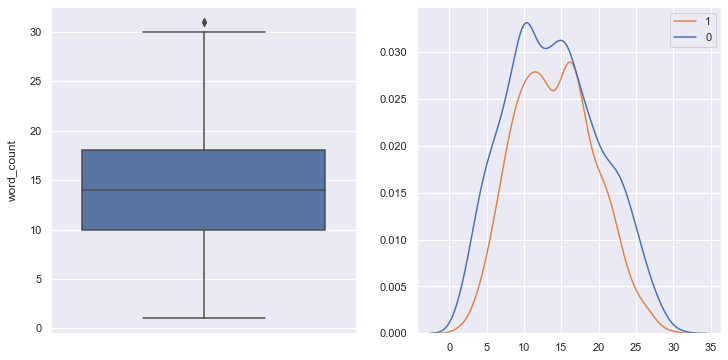

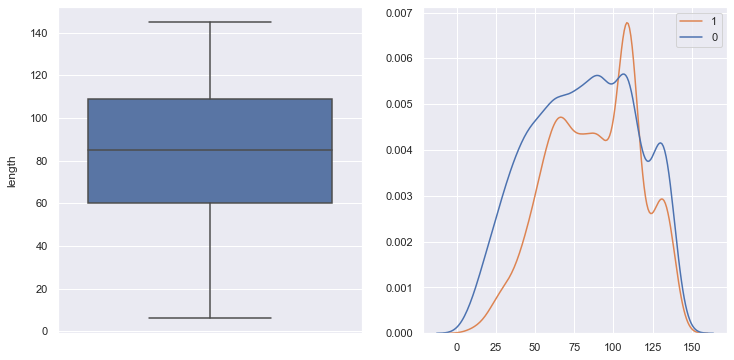

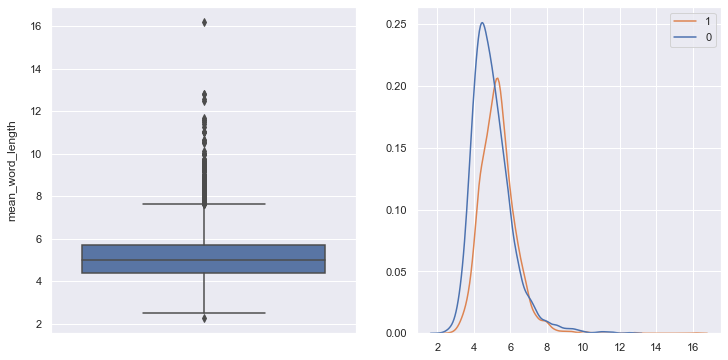

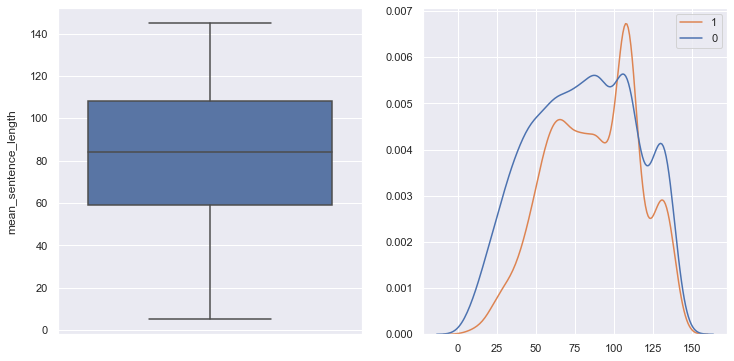

In [79]:
features = train_df.columns.tolist()[7:]
for feature in features:
    visualize(feature)

**Nhận xét**
> 

### Case 5: Tương quan 2 cột `keyword` và `text` để tìm ra mối liên hệ với tweet 1.

**Download thư viện**


In [56]:
!pip install WordCloud


**Import thư viện**


In [80]:
from PIL import Image

**Bước 1**: Trực quan bằng `wordcloud` những dòng có tweet 1.


In [82]:
fpath=("GothamMedium.ttf")

mask = np.array(Image.open("realcloud.png"))
mask=~mask
train_text=train_df.loc[train_df['target']==1].text
train_text=list(train_text.values)
text = " ".join(cat for cat in train_text)
word_cloud = WordCloud(stopwords = STOPWORDS,
                        mask = mask, 
                        background_color = 'white',
                        contour_width=15,
                        contour_color='slateblue',
                        font_path=fpath,
                        max_font_size=600,
                        max_words=200,
                        width = mask.shape[0],
                        height = mask.shape[1],
                        colormap='magma'
                        )
word_cloud.generate(text)

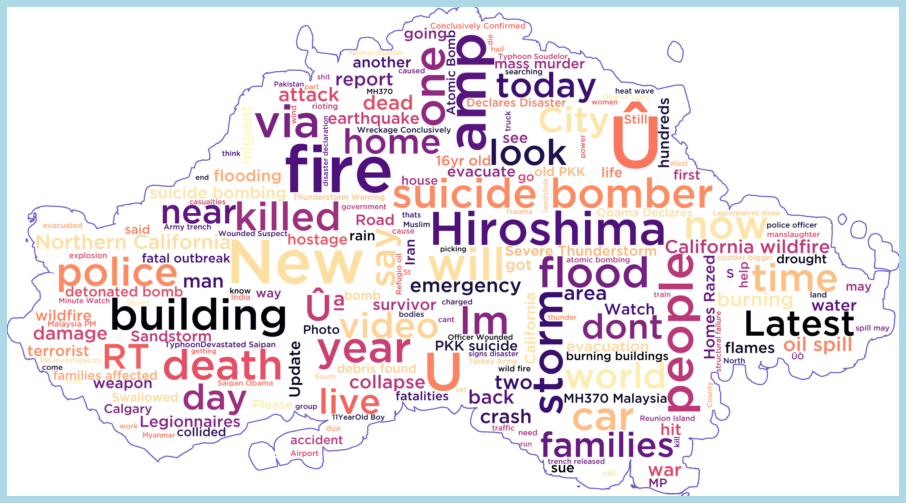

In [83]:
# Display the generated Word Cloud
plt.figure(figsize=(16,9),facecolor='lightblue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Bước 2**: Tìm những `keyword` thường xuất hiện cột `text` trên tweet 1.

In [84]:
word_list = word_cloud.process_text(text)

word_df={}
word_df['word']=word_list.keys()
word_df['count']=word_list.values()
word_df=pd.DataFrame(word_df)
word_df=word_df.sort_values('count',ascending=False).head(5000)
keywords_counts = trainTarget1['keyword'].value_counts().sort_values(ascending=False).head(30)
k=[]
for i in keywords_counts.keys():
    word_check=word_df.loc[word_df['word'].str.contains(i)]
    if word_check.shape[0]!=0:
        k.append(i)
k=np.array(k)
k=keywords_counts.keys()
k

Index(['derailment', 'outbreak', 'wreckage', 'debris', 'typhoon',
       'oil%20spill', 'evacuated', 'rescuers', 'suicide%20bomb',
       'suicide%20bombing', 'nuclear%20disaster', 'razed', 'suicide%20bomber',
       'earthquake', 'airplane%20accident', 'collision', 'wildfire',
       'bridge%20collapse', 'casualties', 'drought', 'sandstorm',
       'mass%20murder', 'buildings%20on%20fire', 'evacuation',
       'forest%20fires', 'devastation', 'hostages', 'bombing', 'wild%20fires',
       'sinkhole'],
      dtype='object')

**Bước 3**: Đếm số lượng tweet 0 và 1 dựa trên các keyword.

In [88]:
t0=0
t1=1
for i in k:
    target_counts=train_ex.loc[train_ex['text'].str.contains(i)].target.value_counts()

    for j in target_counts.keys():
        if j == 0:t0+=target_counts[j]
        else:t1+=target_counts[j]


**Bước 4:** Trực quan bằng `Donut chart`

`Donut chart` phù hợp để thể hiện tỉ lệ số lượng tweet 0 và 1 dựa trên các `keyword` đã tìm được.

In [89]:
target=[1,0]
count=[t1,t0]

pie_chart=go.Pie(labels=target,values=count,hole=0.5,pull=[0, .2])

my_layout=go.Layout(title='Biểu đồ biểu diễn tỉ lệ mức độ nghiêm trọng dựa trên các từ đã tương quan',
                    height=500,width=800)
iplot({'data':pie_chart,'layout':my_layout})


***Nhận xét:***
- Tỉ lệ tweet 1 cao hơn tweet 0 cao hơn rất nhiều dựa trên các `keyword` kiếm được. Có thể lý giải vì...
> Nhưng liệu có bị `overfit` không khi thực hiện như vậy. Tiếp theo, phần `model` sẽ tiến hành tìm hiểu xem.

### Model

**Download thư viện**

In [ ]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install transformers
# !pip install transformers[torch]
# !pip install accelerate -U
# !pip install datasets

**Import thư viện**

In [68]:
from transformers import AutoTokenizer
import torch
import requests
from bs4 import BeautifulSoup
import re
from transformers import Trainer,TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import DatasetDict,Dataset
from transformers import DataCollatorWithPadding
from torch import nn
from transformers import AutoModelForSequenceClassification
from datasets import load_metric

**Tiền xử lý**

In [ ]:
# combine keyword and text
train_df['keyword_text'] = train_df.apply(lambda row: row['keyword'] + ' ' + row['text'], axis=1)
test_df['keyword_text'] = test_df.apply(lambda row: row['keyword'] + ' ' + row['text'], axis=1)

**Chuẩn bị mô hình**

In [69]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'


In [70]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [73]:
df_train,df_valid=train_test_split(train_df,test_size=.15,random_state=42)


In [74]:
dataset=DatasetDict()
dataset['train']=Dataset.from_pandas(df_train)
dataset['validation']=Dataset.from_pandas(df_valid)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'city', 'country', 'location', 'text', 'target', 'keyword_text', '__index_level_0__'],
        num_rows: 6471
    })
    validation: Dataset({
        features: ['id', 'keyword', 'city', 'country', 'location', 'text', 'target', 'keyword_text', '__index_level_0__'],
        num_rows: 1142
    })
})

In [75]:
test=DatasetDict()

test['test']=Dataset.from_pandas(test_df)


In [76]:
def tokenize_sentence(dataset):
    return tokenizer(dataset['keyword_text'],truncation=True,padding=True,max_length=160)

In [77]:
tokenized_sentence=dataset.map(tokenize_sentence,batched=True)
tokenized_sentence

Map:   0%|          | 0/6471 [00:00<?, ? examples/s]

Map:   0%|          | 0/1142 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'city', 'country', 'location', 'text', 'target', 'keyword_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6471
    })
    validation: Dataset({
        features: ['id', 'keyword', 'city', 'country', 'location', 'text', 'target', 'keyword_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1142
    })
})

In [78]:
test_input=test.map(tokenize_sentence,batched=True)

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [79]:
tokenized_sentence=tokenized_sentence.rename_column('target','labels')


In [81]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [82]:
class_weights=(1-(df_train['target'].value_counts().sort_index()/len(df_train))).values
class_weights

array([0.42960902, 0.57039098])

In [83]:
import torch
class_weights=torch.from_numpy(class_weights).float().to('cuda')


In [84]:

class WeightedLossTrainer(Trainer):
    def compute_loss(self,model,inputs,return_outputs=False):


        outputs=model(**inputs)

        logits=outputs.get('logits')

        labels=inputs.get('labels')

        loss_func=nn.CrossEntropyLoss(weight=class_weights)
        loss=loss_func(logits,labels)
        return (loss,outputs) if return_outputs else loss


In [85]:
model = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME,
                                                           num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [86]:
# from sklearn.metrics import f1_score
def compute_metrics(eval_preds):
    metric = load_metric("f1")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

**Huấn luyện mô hình**

In [88]:
from transformers import TrainingArguments
batch_size=64
logging_steps=100
output_dir='output'
training_args=TrainingArguments(output_dir=output_dir,
                                num_train_epochs=10,
                                learning_rate=2e-5,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                weight_decay=0.01,
                                evaluation_strategy='epoch',
                                load_best_model_at_end=True,
                                logging_steps=logging_steps,
                                save_strategy = "epoch")

In [90]:
trainer=WeightedLossTrainer(model=model,
                            args=training_args,
                            compute_metrics=compute_metrics,
                            train_dataset=tokenized_sentence['train'],
                            eval_dataset=tokenized_sentence['validation'],
                            tokenizer=tokenizer)

In [91]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.471800,0.421893,0.787027
2,0.363700,0.421718,0.800847
3,0.291200,0.459530,0.786681
4,0.221400,0.524593,0.781818
5,0.169700,0.578128,0.774775
6,0.133200,0.621003,0.779141
7,0.101100,0.743116,0.762887
8,0.088600,0.763585,0.778926
9,0.067400,0.829783,0.781633
10,0.053000,0.833984,0.783420


<ipython-input-86-5ad16b9f5d62>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


TrainOutput(global_step=1020, training_loss=0.1934825977858375, metrics={'train_runtime': 650.302, 'train_samples_per_second': 99.508, 'train_steps_per_second': 1.569, 'total_flos': 1928681119105800.0, 'train_loss': 0.1934825977858375, 'epoch': 10.0})

In [93]:
import tensorflow as tf
y_test_predict = trainer.predict(test['test'])
y_test_logits = y_test_predict.predictions
y_test_probabilities = tf.nn.softmax(y_test_logits)
y_test_pred_labels = np.argmax(y_test_probabilities, axis=1)

**Lưu mô hình**

In [ ]:
trainer.save_model('saved_model')

**Lưu kết quả**

In [94]:
submit_df={'id':test_df.id,
           'target':y_test_pred_labels}
submit_df=pd.DataFrame(submit_df)

In [97]:
submit_df.to_csv('submit14.csv')


In [96]:
# predictions = trainer.predict(test['test'])
# preds = np.argmax(predictions.predictions, axis=-1)